In [ ]:
!pip3 install jupyterthemes

In [ ]:
 import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import os
import sys
from datetime import datetime
from tqdm.notebook import tqdm
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5, ), std=(0.5, ))])

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(root=".", train=True, 
                                           transform=transform, download=True)
train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=128, 
                                             shuffle=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_generator_block(in_channels, out_channels, kernel_size=3, stride=2, 
                        padding=0,
                        is_final=False):
  
  """
  Function to generate the generator block

  Parameters:
  -----------
  :param in_channels: the number of channels for input
  :param out_channels: the number of channels desired for output
  :param kernel_size: the convolution filter size (default=3)
  :param stride: the sliding window movement (default=2)
  :param padding: the amount of padding to be applied to the image (default=0)
  :param is_final: a bool value to denote whether it is for the final layer (default=False)

  Return:
  --------
  :type ret: torch.nn.Sequential()
  """
  
  if is_final:

    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, 
                  stride=stride, padding=padding, bias=False),
        nn.Tanh()
    )

  else:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,
                  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )



In [ ]:
def get_discriminator_block(in_channels, out_channels, kernel_size=3, stride=2, 
                            padding=0, is_input=False, is_final=False):
  
  """
  Function to build the discriminator block

  Parameters:
  -----------
  
  :param in_channels: the number of channels for the input data
  :param out_channels: the number of channels for the output data
  :param kernel_size: the convolution filter size (default=3)
  :param stride: the sliding window movement value (default=2)
  :param padding: the amount of padding to be applied to the image (default=0)
  :param is_input: a bool value to denote whether it is the initial layer (default=False)
  :param is_final: a bool value to denote whether it is the final layer (default=False)

  Return:
  ------
  :type ret: torch.nn.Sequential()

  """


  if is_input:

    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, 
                  stride=stride, padding=padding, bias=False),
        nn.LeakyReLU(negative_slope=0.2)
    )

  elif is_final:

    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                  stride=stride, padding=padding, bias=False)
    )


  else:

    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(negative_slope=0.2)
    )

In [ ]:
class Generator(nn.Module):
  
  def __init__(self, in_channels, out_channels, hidden_dim=64):

    super(Generator, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.hidden_dim = hidden_dim

    self.gen = nn.Sequential(get_generator_block(self.in_channels, 
                                                 self.hidden_dim*4),
                             get_generator_block(self.hidden_dim*4, self.hidden_dim*2,
                                                 kernel_size=4, stride=1),
                             get_generator_block(self.hidden_dim*2, self.hidden_dim),
                             get_generator_block(self.hidden_dim, self.out_channels, 
                                                 kernel_size=4, is_final=True))
    

  def unsqueeze_noise(self, noise):
    """
    Function to reshape the noise as (batch_size, latent_dim, height=1, width=1)

    Parameters:
    -----------
    :param noise: The noise vector (batch_size, latent_dim)

    Return:
    -------
    :param noise: The noise vector (batch_size, latent_dim, height=1, width=1)
    """

    return noise.view(len(noise), self.in_channels, 1, 1)


  def forward(self, X):
    X = self.unsqueeze_noise(X)
    return self.gen(X)



In [ ]:
class Discriminator(nn.Module):

  def __init__(self, in_channels, out_channels, hidden_dim=64):

    super(Discriminator, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.hidden_dim = hidden_dim


    self.disc = nn.Sequential(get_discriminator_block(self.in_channels, self.hidden_dim, 
                                                      kernel_size=4, stride=2, is_input=True),
                              get_discriminator_block(self.hidden_dim, self.hidden_dim*2,
                                                      kernel_size=4, stride=2),
                              get_discriminator_block(self.hidden_dim*2, self.out_channels,
                                                      kernel_size=4, stride=2, is_final=True))
    


  def forward(self, X):

    return self.disc(X)

In [ ]:
def generate_noise(batch_size, latent_dim, device):
  """
  Function to generate noise from the latent space of shape (batch_size, latent_dim)

  Parmaters:
  ---------
  :param batch_size: the batch size of the noise vector
  :param latent_dim: the latent dimension of the noise vector
  :param device: the device 

  Return:
  ------
  :ret noise: the noise vector of shape (batch_size, latent_dim)
  """

  noise = torch.randn(batch_size, latent_dim, device=device)
  return noise

In [ ]:
def get_one_hot_labels(labels, n_classes):
  """
  Function for creating one-hot vectors for the labels

  Parameters:
  -----------
  :param labels: the batch of labels 
  :param n_classes: the total number of classes

  Return:
  ------
  :ret one_hot: the one hot encoded of the labels
  """
  one_hot = F.one_hot(labels, n_classes)
  return one_hot

In [ ]:
def combine_vectors(noise, one_hot):
  """
  Function to combine the noise vectors with the one-hot coded label vectors

  Parameters:
  -----------
  :param noise: the noise vector of shape (batch_size, ?)
  :param one_hot: the one hot encoded vector of shape (batch_size, ?)

  Return:
  -------
  :ret combined: the combined vector of noise and one_hot 
  """

  combined = torch.cat((noise.float(), one_hot.float()), 1)
  return combined



In [ ]:
fmnist_shape = (1, 28, 28)
n_classes = 10

In [ ]:
def get_input_dimension(latent_dim, fmnist_shape, n_classes):

  """
  Function for getting the size of inputs for conditional generation

  Parameters:
  :param latent_dim: the latent dimension
  :param fmnist_shape: the fashion mnist shape
  :param n_classes: the number of classes

  Return:
  :ret generator_inp: the generator input dimension
  :ret discriminator_inp: the discriminator input dimension
  """

  generator_inp = latent_dim + n_classes
  discriminator_inp = fmnist_shape[0] + n_classes
  return generator_inp, discriminator_inp

In [ ]:
latent_dim = 64
g_inp, d_inp = get_input_dimension(latent_dim, fmnist_shape, n_classes)

G = Generator(g_inp, 1).to(device)
D = Discriminator(d_inp, 1).to(device)


def init_weights(m):

  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)

  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
    torch.nn.init.constant_(m.bias, 0.0)

G = G.apply(init_weights)
D = D.apply(init_weights)


In [ ]:
criterion = nn.BCEWithLogitsLoss()
g_optim = torch.optim.Adam(G.parameters(), lr=2*1e-4, betas=(0.5,0.999))
d_optim = torch.optim.Adam(D.parameters(), lr=2*1e-4, betas=(0.5, 0.999))

In [ ]:
def compute_discriminator_loss(G, D, criterion, real, one_hot_labels, 
                               latent_dim, batch_size, device):
  

  """
  Function to compute the discriminator loss during training

  Parameters:
  -----------
  :param G: the Generator network
  :param D: the Discriminator network
  :param criterion: the Loss function
  :param real: the samples from the training dataset
  :param one_hot_labels: the one-hot encoded labels of the target
  :param latent_dim: the latent dimension
  :param batch_size: the batch size
  :param device: the device to transfer data to 

  Return:
  --------
  :ret disc_loss: the Discriminator loss function
  """

  image_one_hot_labels = one_hot_labels[:, :, None, None]
  image_one_hot_labels = image_one_hot_labels.repeat(1, 1, fmnist_shape[1], 
                                                     fmnist_shape[2])
  
  real_image_labels = combine_vectors(real, image_one_hot_labels)

  real_pred = D(real_image_labels)
  ones_ = torch.ones_like(real_pred).to(device)
  real_loss = criterion(real_pred, ones_)

  noise = generate_noise(batch_size, latent_dim, device)
  noise_and_labels = combine_vectors(noise, one_hot_labels)

  fake = G(noise_and_labels).detach()
  fake_image_labels = combine_vectors(fake, image_one_hot_labels)

  fake_pred = D(fake_image_labels)
  zeros_ = torch.zeros_like(fake_pred).to(device)
  fake_loss = criterion(fake_pred, zeros_)

  disc_loss = 0.5 * (real_loss + fake_loss)

  return disc_loss


In [ ]:
def compute_generator_loss(G, D, criterion, one_hot_labels, latent_dim, 
                           batch_size, device):
  
  """
  Function to compute the generator loss during training

  Parameters:
  -----------
  :param G: the Generator network
  :param D: the Discriminator network
  :param criterion: the Loss function
  :param one_hot_labels: the one hot encoded labels 
  :param latent_dim: the latent dimension
  :param batch_size: the batch size
  :param device: the device to transfer data to

  Return:
  -------
  :ret gen_loss: the Generator loss

  """
  image_one_hot_labels = one_hot_labels[:, :, None, None]
  image_one_hot_labels = image_one_hot_labels.repeat(1, 1, fmnist_shape[1], 
                                                     fmnist_shape[2])
  
  noise = generate_noise(batch_size, latent_dim, device)
  noise_and_labels = combine_vectors(noise, one_hot_labels)

  fake = G(noise_and_labels)
  fake_image_labels = combine_vectors(fake, image_one_hot_labels)

  fake_pred = D(fake_image_labels)
  ones_= torch.ones_like(fake_pred).to(device)
  gen_loss = criterion(fake_pred, ones_)

  return gen_loss


In [ ]:
if not os.path.exists("./IMAGES/"):
  os.mkdir("./IMAGES/")

In [ ]:
def train(train_iter, G, D, criterion, g_optim, d_optim, latent_dim, n_classes, 
          epochs=20, save=True, device=device):
  
  """
  Function to train the GANs network

  Parameters:
  -----------
  :param train_iter: the training data
  :param G: the Generator Network
  :param D: the Discriminator Network
  :param g_optim: the Generator's optimizer
  :param d_optim: the Discriminator's optimizer
  :param latent_dim: the latent dimension
  :param n_classes: the number of classes
  :param epochs: the number of training epochs(default=20)
  :param save: a boolean value whether to save images or not (default=True)
  :param device: the device to move data to.

  Return:
  -------
  :ret gen_losses: the generator losses over the epochs
  :ret disc_losses: the discriminator losses over the epochs
  """

  gen_losses, disc_losses = [], []

  for epoch in range(epochs):
    
    g_loss = []
    d_loss = []
    batch_size = 0
    for real, labels in tqdm(train_iter):

      batch_size = real.size(0)
      real = real.to(device)
      labels = labels.to(device)

      one_hot_labels = get_one_hot_labels(labels, n_classes)

      #########################
      # Train the Discriminator #
      #########################

      d_optim.zero_grad()

      dLoss = compute_discriminator_loss(G, D, criterion, real, one_hot_labels,
                                         latent_dim, batch_size, device)
      
      dLoss.backward()
      d_optim.step()

      d_loss.append(dLoss.item())

      ########################
      # Train the Generator #
      ########################
      gLoss = []
      for _ in range(2):

        g_optim.zero_grad()

        _gLoss = compute_generator_loss(G, D, criterion, one_hot_labels, 
                                        latent_dim, batch_size, device)
        
        _gLoss.backward()
        g_optim.step()

        gLoss.append(_gLoss.item())

      g_loss.append(np.mean(gLoss))

    
    d_loss = np.mean(d_loss)
    g_loss = np.mean(g_loss)

    gen_losses.append(g_loss)
    disc_losses.append(d_loss)

    print(f"Epoch : {epoch + 1}/{epochs} || G Loss : {g_loss} || D Loss : {d_loss}")

    if save:

      noise = generate_noise(batch_size, latent_dim, device)
      labels = torch.randint(0, 10, (batch_size, )).long().to(device)
      oH = get_one_hot_labels(labels, n_classes)

      ioH = oH[:, :, None, None]
      ioH = ioH.repeat(1, 1, fmnist_shape[1], fmnist_shape[2])

      noise_OH = combine_vectors(noise, oH)

      fake_img = G(noise_OH).detach()

      save_image(fake_img, f"./IMAGES/cgans_{epoch+1}.png", normalize=True)


  return gen_losses, disc_losses





In [ ]:
gen_losses, disc_losses = train(train_iterator, G, D, criterion, g_optim, 
                                d_optim, latent_dim, n_classes)


Epoch : 1/20 || G Loss : 0.7712494010355935 || D Loss : 0.6545716975289367



Epoch : 2/20 || G Loss : 0.7069023575609935 || D Loss : 0.6932171922502741



Epoch : 3/20 || G Loss : 0.6987962754550519 || D Loss : 0.6941382039838763



Epoch : 4/20 || G Loss : 0.694084535593163 || D Loss : 0.6947261567817313



Epoch : 5/20 || G Loss : 0.6933845401699863 || D Loss : 0.6944395587134209



Epoch : 6/20 || G Loss : 0.6931739063151101 || D Loss : 0.6940420257257246



Epoch : 7/20 || G Loss : 0.6931152374886754 || D Loss : 0.6938394155583656



Epoch : 8/20 || G Loss : 0.6932326463748143 || D Loss : 0.6936647795410807



Epoch : 9/20 || G Loss : 0.6931106361117698 || D Loss : 0.6935436817120387



Epoch : 10/20 || G Loss : 0.6931903139233335 || D Loss : 0.6934431807827085



Epoch : 11/20 || G Loss : 0.6930549835472473 || D Loss : 0.6933534086894378



Epoch : 12/20 || G Loss : 0.6930948352889974 || D Loss : 0.6933261214543



Epoch : 13/20 || G Loss : 0.6931694019704994 || D Loss : 0.6932891186620636



Epoch : 14/20 || G Loss : 0.6931947600612762 || D Loss : 0.6932413486529515



Epoch : 15/20 || G Loss : 0.6931298734790989 || D Loss : 0.6932285313667265



Epoch : 16/20 || G Loss : 0.6931269288317227 || D Loss : 0.6932079230290232



Epoch : 17/20 || G Loss : 0.6931651860539084 || D Loss : 0.6931950296166101



Epoch : 18/20 || G Loss : 0.6931689562700959 || D Loss : 0.6931825798711797



Epoch : 19/20 || G Loss : 0.6931467727303251 || D Loss : 0.693172173840659



Epoch : 20/20 || G Loss : 0.6931589190512578 || D Loss : 0.6931697577555805


In [ ]:
torch.save(G.state_dict(), "./Generator.pt")
torch.save(D.state_dict(), "./Discriminator.pt")

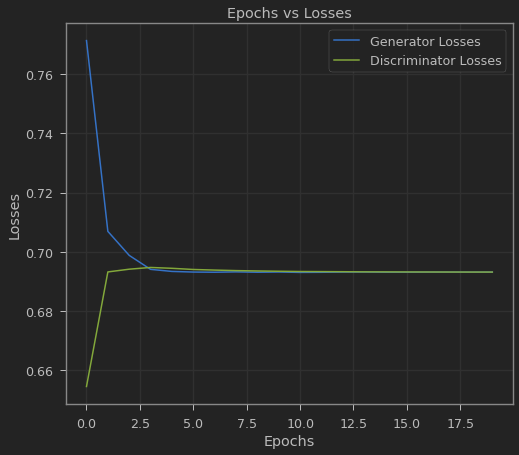

In [ ]:
plt.title("Epochs vs Losses")
plt.plot(gen_losses, label="Generator Losses")
plt.plot(disc_losses, label="Discriminator Losses")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
gen_checkpoint = torch.load("/content/drive/My Drive/Presentation/Generator.pt")
disc_checkpoint = torch.load("/content/drive/My Drive/Presentation/Discriminator.pt")

In [ ]:
G.load_state_dict(gen_checkpoint)
D.load_state_dict(disc_checkpoint)

<All keys matched successfully>

In [ ]:
label = torch.Tensor([8]*128).long().to(device)
one_hot_label = get_one_hot_labels(label, 10)

In [ ]:
noise = generate_noise(128, 64, device)

In [ ]:
noise_oH = combine_vectors(noise, one_hot_label)
fake_img = G(noise_oH)

In [ ]:
save_image(fake_img, "Present.png", normalize=True)